In [1]:
import os, glob, cv2
import numpy as np
import pandas as pd

In [2]:
!pip install -q efficientnet 

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [5]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256



In [6]:
IMG_ROOT = 'input/cataract_dataset/dataset'
IMG_DIR = [os.path.join(IMG_ROOT,'1_normal'), 
           os.path.join(IMG_ROOT,'2_cataract'), 
           os.path.join(IMG_ROOT,'2_glaucoma'), 
           os.path.join(IMG_ROOT,'3_retina_disease')]

In [7]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(42)

In [8]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [9]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths=glob.glob(os.path.join('input/cataract_dataset/dataset*/*/*.png'))


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == 'input\cataract_dataset\dataset\1_normal':    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == 'input\cataract_dataset\dataset\2_cataract':  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == 'input\cataract_dataset\dataset\2_glaucoma':  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == 'input\cataract_dataset\dataset\3_retina':  # retine_disease
        cat_df.iloc[i, 1] = 3
        
cat_df=cat_df.query('0 <= cataract < 2')
print(cat_df)

                                                 paths  cataract
0    input/cataract_dataset\dataset\1_normal/NL_001...         0
1    input/cataract_dataset\dataset\1_normal/NL_002...         0
2    input/cataract_dataset\dataset\1_normal/NL_003...         0
3    input/cataract_dataset\dataset\1_normal/NL_004...         0
4    input/cataract_dataset\dataset\1_normal/NL_005...         0
..                                                 ...       ...
596  input/cataract_dataset\dataset\3_retina_diseas...         0
597  input/cataract_dataset\dataset\3_retina_diseas...         0
598  input/cataract_dataset\dataset\3_retina_diseas...         0
599  input/cataract_dataset\dataset\3_retina_diseas...         0
600  input/cataract_dataset\dataset\3_retina_diseas...         0

[601 rows x 2 columns]


In [10]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(399))

filepaths=glob.glob(os.path.join('input/cataract_dataset/dataset/1_normal/*.png'))
filepaths2=glob.glob(os.path.join('input/cataract_dataset/dataset/2_cataract/*.png'))
i=0;
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    cat_df.iloc[i, 1] = 0

for i2, filepath in enumerate(filepaths2):
    filepath = os.path.split(filepath)
    cat_df.iloc[i+i2, 0] = filepath[0] + '/' + filepath[1]
    cat_df.iloc[i+i2, 1] = 1
        

print(cat_df)

                                                 paths  cataract
0    input/cataract_dataset/dataset/1_normal/NL_001...         0
1    input/cataract_dataset/dataset/1_normal/NL_002...         0
2    input/cataract_dataset/dataset/1_normal/NL_003...         0
3    input/cataract_dataset/dataset/1_normal/NL_004...         0
4    input/cataract_dataset/dataset/1_normal/NL_005...         0
..                                                 ...       ...
394  input/cataract_dataset/dataset/2_cataract/cata...         1
395  input/cataract_dataset/dataset/2_cataract/cata...         1
396  input/cataract_dataset/dataset/2_cataract/cata...         1
397  input/cataract_dataset/dataset/2_cataract/cata...         1
398  input/cataract_dataset/dataset/2_cataract/cata...         1

[399 rows x 2 columns]


In [11]:
cat_df.iloc[0,0]

'input/cataract_dataset/dataset/1_normal/NL_001.png'

In [12]:
#for i, filepath in enumerate(filepaths):
    #filepath = os.path.split(filepath)
  #  print(filepath[0],'/',filepath[1])

In [13]:
#for dir in os.listdir('input/cataract_dataset/dataset/'):
 #   print(dir)

In [14]:
#filepath=glob.glob(os.path.join('input/cataract_dataset/dataset*/*/*.png'))

In [15]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    299
1    100
Name: cataract, dtype: int64


In [16]:
##training split
train_df, test_df = train_test_split(cat_df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=cat_df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [17]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


In [18]:
train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 80/80 [00:06<00:00, 12.32it/s]


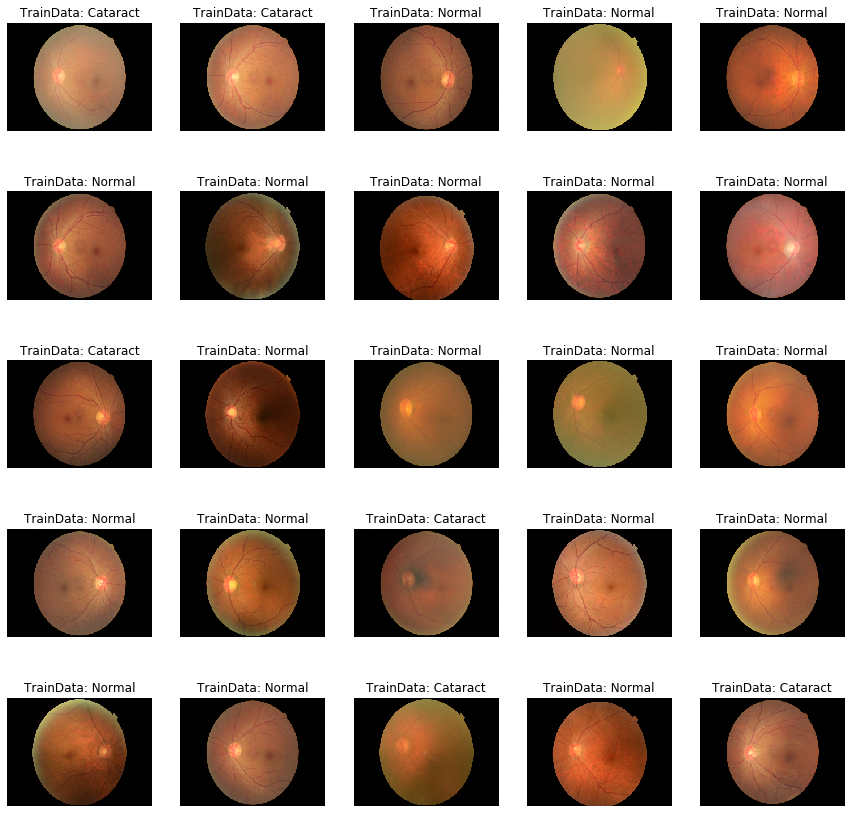

In [41]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][25:50])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.savefig('train_img.png')
plt.show()


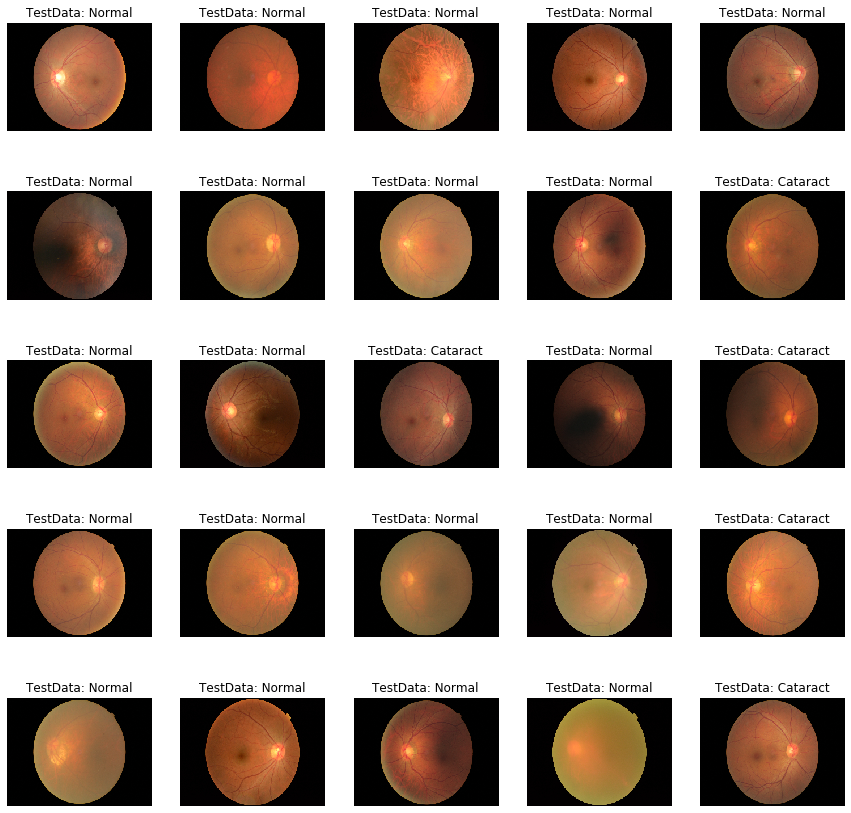

In [40]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][25:50])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.savefig('test_images.png')
plt.show()


In [22]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model=tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                                  
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                  
                                  #
                                 tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                 #
                                  tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                 
                                 tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                  
                                  
                                  #
                                  
                                  #
                                 tf.keras.layers.Flatten(),
                                 #
                                  tf.keras.layers.Dense(256,activation='relu'),
                                  #
                                  tf.keras.layers.Dense(64,activation='relu'),
                                  tf.keras.layers.Dense(16,activation='relu'),
                                  tf.keras.layers.Dense(2,activation='softmax')])

In [23]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 127, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 127, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 125, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 60, 128)       1

In [25]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.15,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/60
9/8 [===============================] - 29s 3s/step - loss: 0.7069 - accuracy: 0.6236 - val_loss: 0.6280 - val_accuracy: 0.7500
Epoch 2/60
9/8 [===============================] - 44s 5s/step - loss: 0.5790 - accuracy: 0.7491 - val_loss: 0.5771 - val_accuracy: 0.7500
Epoch 3/60
9/8 [===============================] - 43s 5s/step - loss: 0.5766 - accuracy: 0.7491 - val_loss: 0.5842 - val_accuracy: 0.7500
Epoch 4/60
9/8 [===============================] - 42s 5s/step - loss: 0.5572 - accuracy: 0.7491 - val_loss: 0.6142 - val_accuracy: 0.7500
Epoch 5/60
9/8 [===============================] - 42s 5s/step - loss: 0.5529 - accuracy: 0.7491 - val_loss: 0.5476 - val_accuracy: 0.7500
Epoch 6/60
9/8 [===============================] - 46s 5s/step - loss: 0.5586 - accuracy: 0.7491 - val_loss: 0.5796 - val_accuracy: 0.7500
Epoch 7/60
9/8 [===============================] - 42s 5s/step - loss: 0.5129 - accuracy: 0.7491 - val_loss: 0.5298 - val_accuracy: 0.7500
Epoch 8/60
9/8 [===========

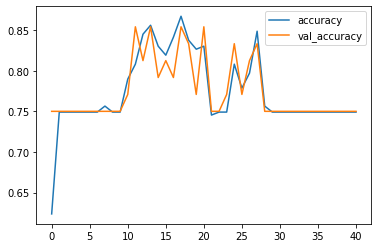

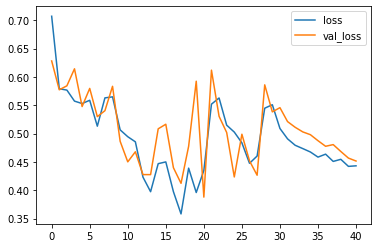

In [26]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=60,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [27]:
model.evaluate(test_imgs, test_df) ##test loss and accuracy

3/3 [==============================] - 2s 708ms/step - loss: 0.3588 - accuracy: 0.8750


[0.35878604650497437, 0.875]

In [29]:
len(test_imgs)

80

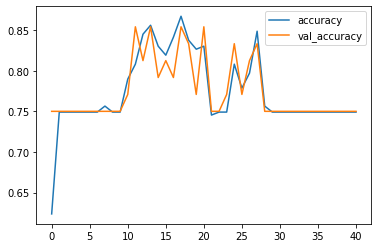

In [44]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.savefig('accuracy.png')
plt.show()


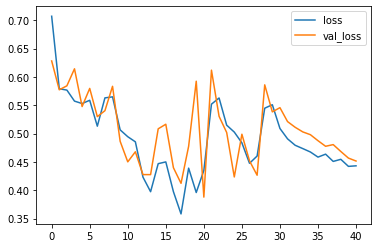

In [45]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.savefig('loss.png')
plt.show()


In [36]:
type(history)

tensorflow.python.keras.callbacks.History

In [39]:
print(pd.DataFrame(history.history))

        loss  accuracy  val_loss  val_accuracy      lr
0   0.706942  0.623616  0.628048      0.750000  0.0010
1   0.578967  0.749077  0.577147      0.750000  0.0010
2   0.576609  0.749077  0.584162      0.750000  0.0010
3   0.557166  0.749077  0.614197      0.750000  0.0010
4   0.552877  0.749077  0.547585      0.750000  0.0010
5   0.558619  0.749077  0.579589      0.750000  0.0010
6   0.512927  0.749077  0.529757      0.750000  0.0010
7   0.562876  0.756458  0.540292      0.750000  0.0010
8   0.564669  0.749077  0.583280      0.750000  0.0010
9   0.506421  0.749077  0.486239      0.750000  0.0010
10  0.494364  0.789668  0.449958      0.770833  0.0010
11  0.485317  0.808118  0.467740      0.854167  0.0010
12  0.423006  0.845018  0.427504      0.812500  0.0010
13  0.397284  0.856089  0.427432      0.854167  0.0010
14  0.446772  0.830258  0.508282      0.791667  0.0010
15  0.449875  0.819188  0.516358      0.812500  0.0010
16  0.397353  0.841328  0.439696      0.791667  0.0010
17  0.3580